In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".13"

In [2]:
import pandas as pd
from brain import BrainModel
from submodels import factories
import matplotlib.pyplot as plt
import pandas as pd
from itertools import accumulate
import numpy as np
from collections import defaultdict
import re

from lib.sde.gene.gene4 import ParamGene4 as ParamGene
from lib.sde.grn.grn4 import GRNMain4 as GRNMain
from lib.sde.mutate import mutate_grn4 as mutate_grn
from lib.sde.util.formula import formula_from_dict, Var

from lib.ga.utils import weighted_selection
from lib.ga.objective import Objective
from jf.profiler import Profiler
from jf.utils.export import Exporter
from jf.autocompute.jf import O

from lib.callback import (
    cell_number_callback, progenitor_number_callback, neuron_number_callback,
    TargetPopulation, TagNumberCallback,
)

from anndata import AnnData
import scanpy as sp

from lib.analyser import show_curve
from lib.score import (
    fate_corr, score_both_size_norm, shrink_and_align_stats, score_stats_norm
)

In [3]:
# exporter(grn, "grn3")

In [4]:
exporter = Exporter("output/grn")
grn = exporter.load("grn3")
grn

Exporting at output/grn


>> G_0: init: 2.01; noise: 2.17; b: 9.54; m: 2.59; expr: 1.45; deg: 0.25; theta: 9.46; asym: 1.40; tree : (3 AND NOT 2)
>> G_1: init: 0.70; noise: 2.24; b: 3.85; m: 6.14; expr: 1.30; deg: 0.70; theta: 2.01; asym: 1.90; tree : NOT 0
>> G_2: init: 0.10; noise: 1.00; b: 1.00; m: 2.50; expr: 1.40; deg: 0.30; theta: 2.80; asym: 8.00; tree : 2
>> G_3: init: 1.20; noise: 5.49; b: 2.44; m: 8.79; expr: 4.36; deg: 1.91; theta: 4.22; asym: 5.70; tree : 4
>> G_4: init: 3.00; noise: 3.00; b: 8.20; m: 7.69; expr: 3.48; deg: 2.33; theta: 2.62; asym: 9.74; tree : (0 OR 2)

In [5]:
REF = O(
    stats=pd.read_csv("reference/ref_tristate2.csv"),  # ref is a mean
    # fmetric=setup_ref_fmetric("output/results/setup_basic/export/ref_fmetric_tristate.csv"),
)

In [6]:
class Solution:
    def __init__(self, grn):
        self.grn = grn
        
    def copy(self):
        return Solution(self.grn.copy())
        
    def mutate(self):
        mutate_grn(self.grn)

In [7]:
def score_bb_size(bb, ref, *args, **kwargs):
    s_prog = score_stats_norm(bb.stats, ref.stats, col_stats=f"progenitor_pop_size",
                     col_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)
    s_all = score_stats_norm(bb.stats, ref.stats, col_stats=f"whole_pop_size",
                     col_ref="whole_pop_size", norm=2.0, *args, **kwargs)
    s_neuron = score_stats_norm(bb.stats, ref.stats, col_stats=f"neuron_pop_size",
                     col_ref="neuron_pop_size", col_norm_data="progenitor_pop_size",
                       col_norm_ref="progenitor_pop_size", norm=2.0, *args, **kwargs)
    print(s_prog, s_all, s_neuron)
    return s_prog + s_all + 0.1 * s_neuron

In [8]:
class ObjectiveStep(O):
    start_time = 0
    end_time = 0
    max_fitness = 3
    min_fitness = 1
    name = ""
    _passed = False
    
    def reset(self):
        self._passed = False
    
    def passed(self):
        if self._passed:
            return
        print(f"Step {self.name} passed !")
        self._passed = True

example_steps = [
    ObjectiveStep(name="1", start_time=50, end_time=53, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="2", start_time=53, end_time=56, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="3", start_time=56, end_time=59, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="4", start_time=59, end_time=62, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="5", start_time=62, end_time=65, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="6", start_time=65, end_time=68, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="7", start_time=68, end_time=71, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="8", start_time=71, end_time=74, score_func=score_bb_size, min_fitness=0.2),
    ObjectiveStep(name="9", start_time=74, end_time=77, score_func=score_bb_size, min_fitness=0.2),
]

class ParamRun(O):
    pop_size = 10
    n_gen = 10
    current_gen = 0
    end_time = 83
    ref = REF
    min_pop = 20
    max_pop = 50
    steps = example_steps
    
prun = ParamRun()

In [9]:
def fitness_multistep(prun, grn, steps):
    total_fitness = 0
    stop = False
    previous_time = None
    bb = get_bb(prun, grn)
    # first step
    for step in steps:
        if not bb.run_until(step.end_time):
            stop = True
        # score_step = score_both_size(bb.stats, prun.ref, max_step=step.end_time, min_step=previous_time)
        score_step = step.score_func(bb, prun.ref, max_step=step.end_time, min_step=step.start_time)
        fitness_step = 1.0 / score_step
        fitness_step = min(fitness_step, step.max_fitness)
        total_fitness += fitness_step
        if fitness_step < step.min_fitness or stop:
            return total_fitness, bb
        else:
            previous_time = step.end_time
            step.passed()
        
    return total_fitness, bb

In [10]:
def get_bb(prun, grn):
    ccls = factories["grn4"](grn=grn)
    callbacks = dict(
        progenitor_pop_size=progenitor_number_callback,
        whole_pop_size=cell_number_callback,
        neuron_pop_size=neuron_number_callback,
    )
    bb = BrainModel(time_step=0.5, verbose=False, start_population=5, max_pop_size=1e3,
            cell_cls=ccls, end_time=90, start_time=50, silent=True, record_population=True,
              monitor_callbacks=callbacks, opti=True)
    return bb

In [11]:
def run_grn(prun, grn):
    get_bb(prun, grn)
    bb.run()
    return bb

In [113]:
GRNMain(5, 0, 1)

>> G_0: init: 0.28; noise: 7.33; b: 8.46; m: 1.51; expr: 3.67; deg: 0.60; theta: 2.70; asym: 0.56; tree : NOT 3
>> G_1: init: 1.16; noise: 3.46; b: 3.99; m: 9.53; expr: 3.14; deg: 0.93; theta: 9.29; asym: 0.52; tree : NOT 1
>> G_2: init: 2.63; noise: 4.80; b: 8.47; m: 1.77; expr: 1.10; deg: 1.79; theta: 7.56; asym: 8.65; tree : NOT 4
>> G_3: init: 1.91; noise: 9.68; b: 8.48; m: 3.43; expr: 0.62; deg: 1.50; theta: 8.08; asym: 3.12; tree : (0 AND 5)
>> G_4: init: 1.07; noise: 2.63; b: 1.04; m: 9.65; expr: 1.78; deg: 0.84; theta: 4.38; asym: 9.85; tree : 1

In [54]:
ParamGene.expr

4

In [80]:
formula_from_dict(dict(op="Not", F=dict(op="Var", val=0)))

NOT 0

In [110]:
grn.set_mutable()
grn._params[ParamGene.m, 2] = 2.5
# grn.genes[2].tree = formula_from_dict(dict(op="Var", val=2))
# grn.genes[2].tree = formula_from_dict(dict(op="Not", F=dict(op="Var", val=0)))
# grn.genes[0].tree = formula_from_dict(dict(op="And", F1=dict(op="Var", val=3), F2=dict(op="Not", F=dict(op="Var", val=2))))
grn.compile()

In [12]:
grn

>> G_0: init: 2.01; noise: 2.17; b: 9.54; m: 2.59; expr: 1.45; deg: 0.25; theta: 9.46; asym: 1.40; tree : (3 AND NOT 2)
>> G_1: init: 0.70; noise: 2.24; b: 3.85; m: 6.14; expr: 1.30; deg: 0.70; theta: 2.01; asym: 1.90; tree : NOT 0
>> G_2: init: 0.10; noise: 1.00; b: 1.00; m: 2.50; expr: 1.40; deg: 0.30; theta: 2.80; asym: 8.00; tree : 2
>> G_3: init: 1.20; noise: 5.49; b: 2.44; m: 8.79; expr: 4.36; deg: 1.91; theta: 4.22; asym: 5.70; tree : 4
>> G_4: init: 3.00; noise: 3.00; b: 8.20; m: 7.69; expr: 3.48; deg: 2.33; theta: 2.62; asym: 9.74; tree : (0 OR 2)

In [12]:
with Profiler():
    fitness_multistep(prun, grn, prun.steps)

0.19897307000245418 0.24586093567860115 2.12044236910576
Step 1 passed !
0.3174020221973351 0.010902280500569714 2.754540581916092
Step 2 passed !
0.061964007222423956 0.003499849184466609 0.1393863200995477
Step 3 passed !
0.019695070766721542 0.05519137116624739 0.11114444638870681
Step 4 passed !
0.07340072968014073 0.12227894197190434 0.17240864829426555
Step 5 passed !
0.25793858699861527 0.15128908226381851 0.10811832194908234
Step 6 passed !
0.4355689531113085 0.140670574613857 0.06919675101500636
Step 7 passed !
1.0570281991530133 0.11108422924763244 0.019480978362984798
Step 8 passed !
2.8524511167658453 0.10378473752685227 0.0004449347467701159
Step 9 passed !
         140998223 function calls (134375176 primitive calls) in 131.733 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000  131.747  131.747 <ipython-input-9-296e65aa88c4>:1(fitness_multistep)
        9    0.000    0.000  131.126 

In [15]:
bb = get_bb(prun, grn)

In [19]:
c = bb.population.base_population[0]

In [22]:
c.cell_program.activation, c.cell_program.environment

(DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
 DeviceArray([0.], dtype=float32))

0.05231692117114695 0.10798045644334722 0.784355882619273
0.02512031935488275 0.10367806044557246 1.911961047257123
0.05381781229423678 0.1783404180559161 0.6729541759906286
0.42506213838798124 0.45255831923027634 0.4830986855550406
0.5427159060705312 0.6494252053308737 0.7479416792087223
0.6782750393282584 0.6941081080871168 0.7085271555826615
1.282381908906113 0.6269289987650152 0.43300105845212644
2.6587473424591317 0.5704087206741675 0.2461094429304591
6.631644768311764 0.5952177376861029 0.14366877993328608
Fit 12.519757559815336


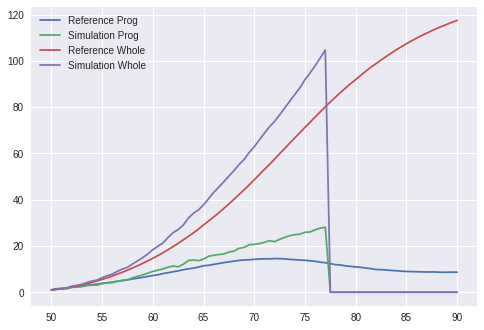

In [121]:
fit, bb = fitness_multistep(prun, grn, prun.steps)
print("Fit", fit)
show_curve(bb.stats, REF.stats)

In [57]:
from lib.utils import (shrink_and_align_stats, align_time, normalize_time,
                       shrink_time, as_time_lists)

def score_stats_norm(stats, ref, col_stats, col_ref, max_step=None, min_step=None,
                     norm=1, col_norm_data=None, col_norm_ref=None):
    stats, ref = align_time(stats, ref)
    return stats, ref
    stats, ref = normalize_time(stats, ref, col_data=col_stats, col_ref=col_ref,
                               col_norm_data=col_norm_data, col_norm_ref=col_norm_ref)
    return stats, ref
    stats, ref = shrink_time(stats, ref, min_step, max_step)
    
    x, y = as_time_lists(stats, ref, col_data=col_stats, col_ref=col_ref)
    
    return score_coefficient_variation_norm(x, y, norm=norm)

In [58]:
x, y = score_stats_norm(bb.stats, REF.stats, col_stats=f"neuron_pop_size",
                     col_ref="neuron_pop_size", col_norm_data="progenitor_pop_size",
                       col_norm_ref="progenitor_pop_size", norm=2.0, min_step=71,
                       max_step=74)

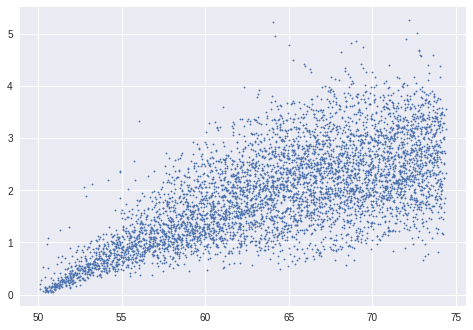

In [109]:
def gene_time(bb, gene_id):
    ls_x = []
    ls_y = []
    for age, d in bb.snapshots.items():
        pop = list(d["population"].values())
        for indiv in pop:
            ls_x.append(age + np.random.normal(0, 0.2))
            ls_y.append(indiv[gene_id])
            
    plt.scatter(ls_x, ls_y, s=2)

gene_time(bb, 2)

In [32]:
np.array(list(bb.snapshots[50.5]["population"].values()))[:5]

array([[1.7560537e-01, 4.8333445e-01, 6.4565116e-05, 2.3251548e+00,
        6.5270233e-01],
       [8.7772977e-01, 5.1021707e-01, 6.0900324e-03, 2.2603748e+00,
        3.1076628e-01],
       [7.0614600e-01, 2.9233289e-01, 5.6401337e-04, 2.1143091e+00,
        5.6548703e-01],
       [5.7986265e-01, 3.4553695e-01, 0.0000000e+00, 1.6462314e+00,
        4.0646333e-01],
       [7.8474772e-01, 3.4633249e-01, 5.1424474e-02, 2.1030967e+00,
        2.3925216e-01]], dtype=float32)

In [12]:
from lib.sde.cell.cell4 import Cell4, CellBatch4

In [15]:
c1 = Cell4(grn)
c2 = Cell4(grn, quantities=c1.quantities)
print(c1.quantities)
print(c2.quantities)
q0 = c1.quantities

[1.1241983  2.3787758  0.00624915 0.09795278 1.7990332 ]
[1.1241983  2.3787758  0.00624915 0.09795278 1.7990332 ]


In [16]:
cell_programs = [c1]
batch = CellBatch4(cell_programs)
batch.run_step(0.5)
c2.run_step(0.5)
print(c1.quantities, c1.activation, c1.derivative, c1.expression, sep="\n")
print()
print(c2.quantities, c2.activation, c2.derivative, c2.expression, sep="\n")

[0.7752276  1.925007   0.06640543 2.1089582  0.81064606]
[0.5771763  0.9990304  0.07185925 0.01123263 0.9999664 ]
[-0.26593265 -1.1154722   0.0987282   4.1735477  -2.080115  ]
[0.01042546 0.42282373 0.07185925 0.9999664  0.60756004]

[0.88079363 1.7061765  0.05383847 2.1430905  0.7461352 ]
[0.5771763  0.9990304  0.07185925 0.01123263 0.9999664 ]
[-0.26593265 -1.1154722   0.0987282   4.1735477  -2.080115  ]
[0.01042546 0.42282373 0.07185925 0.9999664  0.60756004]


In [21]:
import jax.numpy as jnp
from lib.sde.util.sde import step_euler_sde3, j_step_euler_sde
from lib.sde.cell.cell4 import batch_compute_quantities
from lib.sde.util.sde import noise, j_noise, j_single_deltaW
from jax import random

In [18]:
ts = 0.5

In [19]:
jnp.array(step_euler_sde3(q0, c1.derivative, noise, ts,
                                                   grn.noise))

DeviceArray([0.94015163, 2.0412638 , 0.05664359, 2.145051  , 0.52021277],            dtype=float32)

In [28]:
key = random.PRNGKey(14)
batch_compute_quantities([q0], [c1.derivative], grn.noise, ts, key)

[DeviceArray([1.0907906 , 1.9907945 , 0.05428285, 2.2499363 , 0.8066978 ],            dtype=float32)]

In [209]:
j_step_euler_sde(q0, c1.derivative, grn.noise, 0.501)

DeviceArray([1.1749504 , 1.3552197 , 0.09112556, 3.5762372 , 3.3678226 ],            dtype=float32)

In [224]:
def j_step_euler_sde_2(quantities, derivatives, noise_param, ts):
    d = len(quantities)
    dW = j_single_deltaW(d, ts)
    print(dW)
    print(jnp.multiply(j_noise(quantities, noise_param), dW))
    y_ = quantities \
         + derivatives * ts \
         + jnp.multiply(j_noise(quantities, noise_param), dW)
    # Ensure positive terms
    y_ = jnp.maximum(y_, 0)

    return y_

j_step_euler_sde_2(q0, c1.derivative, grn.noise, 0.501)

-0.98809564
[-1.2982785  -1.2783285  -0.05845748 -2.1265116  -4.174665  ]


DeviceArray([0.        , 0.        , 0.        , 0.06490731, 0.        ],            dtype=float32)

In [225]:
grn.noise

DeviceArray([2.1712358, 2.2397077, 1.       , 5.489225 , 3.       ], dtype=float32)

In [255]:
from jax import jit, random

def j_single_deltaW_2(x, ts):
    """Generate Wiener increments for m independent Wiener
    From the sdeint implementation
    The result is multiplied by the ts as low time step
    means that noise shall not affect a lot
    """
    seed = np.random.randint(4294967295)
    key = random.PRNGKey(seed)
    return random.normal(key, x.shape) * ts

@jit
def test1():
    return j_single_deltaW_2(jnp.zeros((3,)), 0.5)

def test2():
    return j_single_deltaW_2(jnp.zeros((3,)), 0.5)

In [256]:
test1(), test2(), test1(), test2()

(DeviceArray([0.5163404 , 0.08859801, 0.36919403], dtype=float32),
 DeviceArray([ 0.31113523, -0.49872032,  0.5974713 ], dtype=float32),
 DeviceArray([0.5163404 , 0.08859801, 0.36919403], dtype=float32),
 DeviceArray([-0.131517  , -0.05943361,  0.95238364], dtype=float32))

## Setup scanpy

In [38]:
def build_scanpy_dataset(bb):
    # export expressions
    vec_age = []
    vec_gene_quantity = []
    for age in bb.snapshots:
        for gene_quantity in bb.snapshots[age]["population"].values():
            vec_age.append(age)
            vec_gene_quantity.append(gene_quantity)

    n_obs = len(vec_age)
    id_cells = np.arange(n_obs, dtype=int).astype(str)
    
    # metadata
    id_genes = np.array([f"gene_{i}" for i in range(len(vec_gene_quantity[0]))])
    obs_meta = pd.DataFrame({
        "age": np.array(vec_age)
    }, index=id_cells)
    
    # build dataset
    df = pd.DataFrame(np.array(vec_gene_quantity), columns=id_genes, index=id_cells)
    dts = AnnData(df, obs=obs_meta)
    
    return dts

In [61]:
dts = build_scanpy_dataset(bb)

In [62]:
sp.pp.neighbors(dts)

In [63]:
sp.tl.umap(dts)

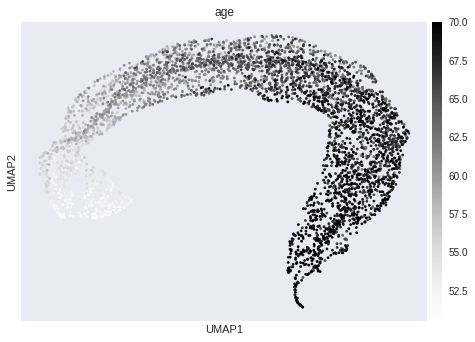

In [64]:
sp.pl.umap(dts, color="age")

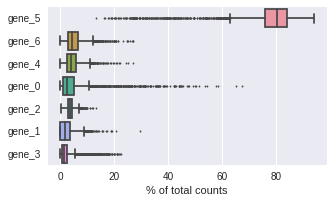

In [54]:
sp.pl.highest_expr_genes(dts, n_top = 7, save = True)

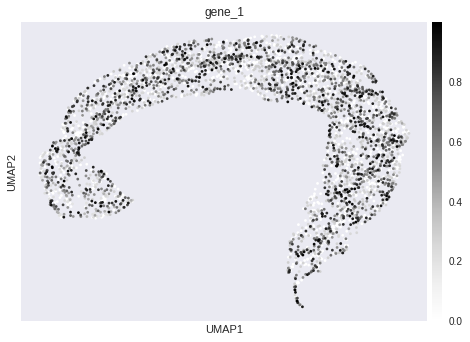

In [72]:
sp.pl.umap(dts, color="gene_1")